### Importy

In [1]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# w celu logowania czasu wykonania
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### Prosty autoenkoder

Określamy wymiar przestrzeni ukrytej (im niższy wymiar tym bardziej skompresowane dane) i budujemy model autoenkodera

In [3]:
encoding_dim = 15  # wymiar kodowania skompresowanego
input_img = Input(shape=(784,), name='Warstwa_wejściowa') # warstwa wejsciowa
encoded = Dense(encoding_dim, activation='relu', name='Enkoder')(input_img) # reprezentacja zakodowana
decoded = Dense(784, activation='sigmoid', name='Dekoder')(encoded) # reprezentacja zdekodowana
autoencoder = Model(input_img, decoded, name='Prosty_autoenkoder') # model autoenkodera

Tworzymy enkoder i dekoder

In [4]:
encoder = Model(input_img, encoded) # model enkodera
encoded_input = Input(shape=(encoding_dim,)) # input dla dekodera
decoder_layer = autoencoder.layers[-1] # ostatnia warstwa autoenkodera czyli dekoder
decoder = Model(encoded_input, decoder_layer(encoded_input)) # model dekodera

Ustawiamy optymalizator i funkcję straty

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Wczytanie zbioru danych MNIST 

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [7]:
plt.imshow(x_train[1][200:300].reshape(1,100))
plt.axis('off')
plt.gray()

Przykładowe obrazy ze zbioru treningowego:

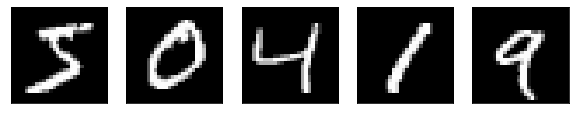

In [8]:
plt.figure(figsize=(10, 4))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Trenujemy model autoenkodera

In [9]:
time_callback = TimeHistory()

In [10]:
history=autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=256,
                validation_data=(x_test, x_test),
                callbacks=[time_callback])

Epoch 1/15
235/235 [==============================] - 3s 9ms/step - loss: 0.3108 - val_loss: 0.2283
Epoch 2/15
235/235 [==============================] - 2s 7ms/step - loss: 0.2036 - val_loss: 0.1837
Epoch 3/15
235/235 [==============================] - 1s 6ms/step - loss: 0.1749 - val_loss: 0.1643
Epoch 4/15
235/235 [==============================] - 1s 6ms/step - loss: 0.1599 - val_loss: 0.1536
Epoch 5/15
235/235 [==============================] - 2s 8ms/step - loss: 0.1521 - val_loss: 0.1482
Epoch 6/15
235/235 [==============================] - 1s 6ms/step - loss: 0.1479 - val_loss: 0.1451
Epoch 7/15
235/235 [==============================] - 2s 7ms/step - loss: 0.1453 - val_loss: 0.1429
Epoch 8/15
235/235 [==============================] - 2s 7ms/step - loss: 0.1433 - val_loss: 0.1413
Epoch 9/15
235/235 [==============================] - 2s 8ms/step - loss: 0.1417 - val_loss: 0.1397
Epoch 10/15
235/235 [==============================] - 1s 6ms/step - loss: 0.1402 - val_loss: 0.1382

Stosujemy enkoder i dekoder na zbiorze testowym. Wyświetlamy oryginalne obrazy ze zbioru testowego oraz ich rekonstrukcje z autoenkodera

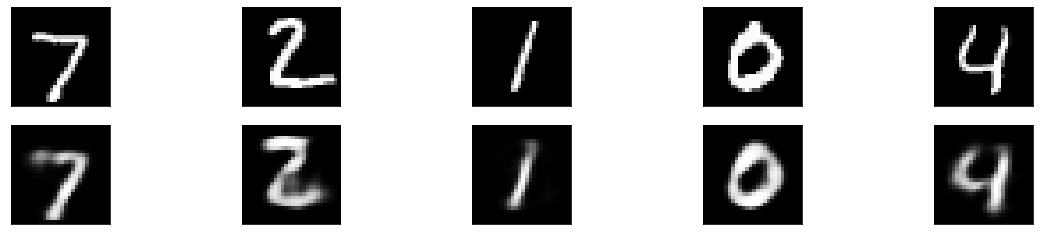

In [11]:
encoded_img = encoder.predict(x_test)
decoded_img = decoder.predict(encoded_img)
plt.figure(figsize=(20, 4))
for i in range(5):
    #wyswietlanie oryginalu
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # wyswietlanie rekonstrukcji
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Jak wygląda skompresowana forma danych?

Zbiór testowy po zakodowaniu przy użyciu enkodera ma wymiar 10000 na 15, czyli zawiera 10 tysięcy obserwacji, każda jest wektorem o długości 15 (wejściowe obrazy były przedstawione jako wektory o długości 784).

In [12]:
encoded_img.shape

(10000, 15)

Przykładowe kodowanie obserwacji ze zbioru testowego:

In [13]:
encoded_img[0]

array([ 7.511899 ,  7.8451395,  5.2163234,  3.1983633, 12.948946 ,
        4.4621706,  9.429525 ,  3.630723 , 15.117029 , 15.410699 ,
        5.4545302, 11.368088 ,  0.       ,  3.7004268, 12.686624 ],
      dtype=float32)

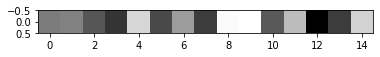

In [14]:
#plt.figure(figsize=(4, 8))
plt.imshow(encoded_img[0].reshape(1,15))
plt.show()

In [15]:
autoencoder.summary()

Model: "Prosty_autoenkoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Warstwa_wejściowa (InputLay  [(None, 784)]            0         
 er)                                                             
                                                                 
 Enkoder (Dense)             (None, 15)                11775     
                                                                 
 Dekoder (Dense)             (None, 784)               12544     
                                                                 
Total params: 24,319
Trainable params: 24,319
Non-trainable params: 0
_________________________________________________________________


In [16]:
loss=history.history['loss']
epoch=history.epoch

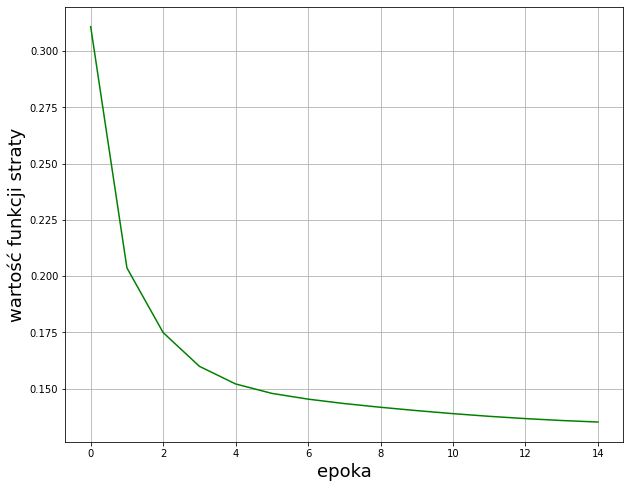

In [17]:
fig = plt.figure(figsize=(10,8))
plt.plot(epoch, loss, 'g')
plt.ylabel("wartość funkcji straty", fontsize=18)
plt.xlabel("epoka", fontsize=18)
plt.grid(True)
plt.show()

In [18]:
autoencoder.save_weights('simple_autoencoder.h5')

In [19]:
time_callback.times

[2.6767971515655518,
 1.5652294158935547,
 1.3465864658355713,
 1.4771263599395752,
 1.8365809917449951,
 1.4313583374023438,
 1.695847511291504,
 1.5429227352142334,
 1.9928650856018066,
 1.4524455070495605,
 1.9971411228179932,
 1.283036708831787,
 1.52899169921875,
 1.7731349468231201,
 1.2519636154174805]

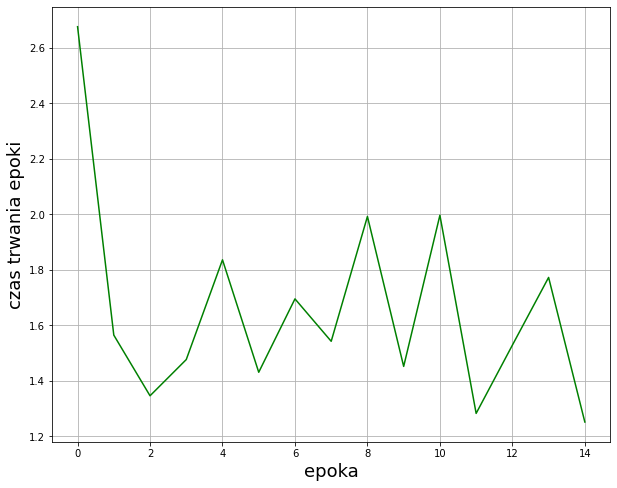

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot(epoch, time_callback.times, 'g')
plt.ylabel("czas trwania epoki", fontsize=18)
plt.xlabel("epoka", fontsize=18)
plt.grid(True)
plt.show()

In [21]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Warstwa_wejściowa (InputLay  [(None, 784)]            0         
 er)                                                             
                                                                 
 Enkoder (Dense)             (None, 15)                11775     
                                                                 
Total params: 11,775
Trainable params: 11,775
Non-trainable params: 0
_________________________________________________________________


In [22]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 Dekoder (Dense)             (None, 784)               12544     
                                                                 
Total params: 12,544
Trainable params: 12,544
Non-trainable params: 0
_________________________________________________________________
